In [37]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [38]:
print(tf.__version__)

2.4.1


# Download and explore the IMDB dataset

In [39]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                              untar=True, cache_dir='.',
                              cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [40]:
# Looking into at directory contents
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [41]:
# Creating train directory
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [42]:
# The aclImdb/train/pos and /neg directory contains thousands of text files each one a single review
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load the dataset

In [43]:
# Loading the data off the disk and into two folder class_a and class_b to prepare for training 
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [44]:
# Using text_dataset_from_directory utility to create a labelled tf.data.Dataset 
# with train/validation/test sets from the loaded aclImdb/train directory
# The utlity locates and quantifies the files selecting 80% for training 
batch_size = 32
seed = 2020

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(\
                                                                  'aclImdb/train', 
                                                                  batch_size=batch_size,
                                                                  validation_split = 0.2, #specifying split
                                                                  subset ='training', # specifying the portion used
                                                                  seed = seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [45]:
# Lets print some tf.data examples using .numpy() convert from tf.data
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('Review', text_batch.numpy()[i])
        print('Label', label_batch.numpy()[i], '\n')

Review b"This is one of the best movies I've ever seen. It has very good acting by Hanks, Newman, and everyone else. Definitely Jude Law's best performance. The cinematography is excellent, the editing is about as good, and includes a great original score that really fits in with the mood of the movie. The production design is also a factor in what makes this movie special. To me, it takes a lot to beat Godfather, but the fantastic cinematography displayed wins this contest. Definitely a Best Picture nominee in my book."
Label 1 

Review b"New York, I Love You, or rather should-be-titled Manhattan, I Love Looking At Your People In Sometimes Love, is a precise example of the difference between telling a story and telling a situation. Case in point, look at two of the segments in the film, one where Ethan Hawke lights a cigarette for a woman on a street and proceeds to chat her up with obnoxious sexy-talk, and another with Orlando Bloom trying to score a movie with an incredulous demand 

In [46]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print('Label 1 corresponds to', raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [47]:
# Using text_dataset_from_directory utility to create a labelled tf.data.Dataset 
# with train/validation/test sets from the loaded aclImdb/train directory
# The utlity locates and quantifies the files selecting 20% for validation 
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(\
                                                               'aclImdb/train',
                                                               batch_size = batch_size,
                                                               validation_split=0.2,
                                                               subset='validation', # Specifying the portion used
                                                               seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [48]:
# Specifying the entire dataset for testing dont set split, subset, seed
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(\
                                                                 'aclImdb/test',
                                                                  batch_size = batch_size)
                                                                 


Found 25000 files belonging to 2 classes.


# Prepare the dataset for training
* Removing HTML requires custom standardization function to be added into TextVectorization
* Cleaning the text
* Removing punctuation
* Lower casing

In [49]:
# Using tensorflows tf.strings API call with regex_replace
def custom_standardization(input_data):
    # Lowercase then regex replace
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    # Returning stripped html and further stripping special characters
    return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

In [50]:
# Creating a TextVectorization layer to standardize, tokenize, and vectorize the data
# Set the output_mode to int to create unique integer indices for each token.
max_features = 10000
sequence_length = 250 # Maximum length (truncation/padding)

vectorize_layer = TextVectorization(\
                                   standardize=custom_standardization,
                                   max_tokens = max_features,
                                   output_mode = 'int',
                                   output_sequence_length=sequence_length)


In [51]:
# Adapt fits the vectorize_layer to the dataset
# Removing the labels from the training tf.dataset 
train_text = raw_train_ds.map(lambda x, y:x) # removes labels 
# Fitting the vectorizing layer to train_text
vectorize_layer.adapt(train_text)

In [52]:
#Custom function to display the result of the vectorization
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label # Returns expanded text and from the predefined vectorization layer

In [53]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('Review', first_review)
print('label', raw_train_ds.class_names[first_label])
print('Vectorization', vectorize_text(first_review, first_label))

Review tf.Tensor(b"I am not a parent, neither am I a male. But I was able to identify with every character's heartaches and pains.<br /><br />This is a movie teenagers should watch. Maybe that way they will start appreciating the value of family again. I'm sorry for those that don't understand the value of love, family and friendship.<br /><br />It was very interesting to watch Patrick Duffy in a different role than that of Bobby Ewing. And it is great to see a 19 year old Ben Affleck giving his best in a moving and sincere performance. He showed at an early age, that he is capable of heartfelt drama. He should be offered more serious roles. Note Hollywoodland... his first serious role in years and he went out and won Best Actor at the Venice Festival in 2006.<br /><br />This movie can be appreciated by people of all ages. Maybe shouldn't be watched by children under 10 because they might get scared that the same may happen to their families, but I recommend it to the entire family.<br

In [54]:
# Exploring the tokens using the vectorizer layers get_vocabulary()
print('Token No. 595 corresponds to the word', vectorize_layer.get_vocabulary()[595])
print('Token No. 6522 corresponds to the word', vectorize_layer.get_vocabulary()[6522])
print('Vocab size: {}'.format(len(vectorize_layer.get_vocabulary())))

Token No. 595 corresponds to the word please
Token No. 6522 corresponds to the word nbc
Vocab size: 10000


In [55]:
# Applying the vectorize_text function/vectorize_layer on the train, validation, and test dataset

train_df = raw_train_ds.map(vectorize_text) # Custom function only vectorizes text
val_df = raw_val_ds.map(vectorize_text)
test_df = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance

In [56]:
# .cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck 
# .prefetch() overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.AUTOTUNE

train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
val_df = val_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)


# Create The Model

In [57]:
# Create The Model

embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features+1, embedding_dim), # takes the integer-encoded reviews and looks up an embedding vector for each word-index
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(), # returns a fixed-length output vector for each example by averaging over the sequence dimension
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


# Loss function and optimizer

In [58]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics = tf.metrics.BinaryAccuracy(threshold=0.0))

# Train the model

In [59]:
epochs = 15

history = model.fit(train_df,
                    validation_data=val_df,
                   epochs=epochs)

Epoch 1/15
625/625 [==============================] - 10s 16ms/step - loss: 0.6825 - binary_accuracy: 0.6158 - val_loss: 0.6156 - val_binary_accuracy: 0.7696
Epoch 2/15
625/625 [==============================] - 2s 4ms/step - loss: 0.5798 - binary_accuracy: 0.7905 - val_loss: 0.4989 - val_binary_accuracy: 0.8212
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 0.4636 - binary_accuracy: 0.8426 - val_loss: 0.4224 - val_binary_accuracy: 0.8438
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.3876 - binary_accuracy: 0.8689 - val_loss: 0.3780 - val_binary_accuracy: 0.8548
Epoch 5/15
625/625 [==============================] - 2s 3ms/step - loss: 0.3393 - binary_accuracy: 0.8813 - val_loss: 0.3508 - val_binary_accuracy: 0.8622
Epoch 6/15
625/625 [==============================] - 2s 3ms/step - loss: 0.3051 - binary_accuracy: 0.8913 - val_loss: 0.3325 - val_binary_accuracy: 0.8692
Epoch 7/15
625/625 [==============================] - 2s 3ms/s

# Evaluate the model

In [60]:
loss, accuracy = model.evaluate(test_df)
print('Loss: ', loss)
print('Accuracy: ', accuracy)

782/782 [==============================] - 12s 15ms/step - loss: 0.3146 - binary_accuracy: 0.8715
Loss:  0.31460797786712646
Accuracy:  0.8714799880981445


# Create a plot of accuracy and loss over time

In [61]:
# model.fit() returns a History object that contains a dictionary with everything that happened during training

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

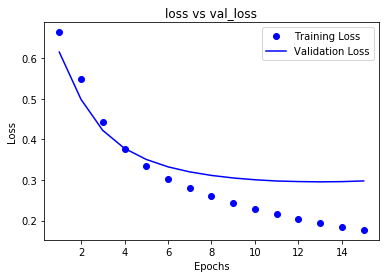

In [62]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

# Plot loss vs val_loss 
plt.plot(epochs, loss, 'bo', label ='Training Loss')
plt.plot(epochs, val_loss, 'b', label ='Validation Loss')
plt.title('loss vs val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

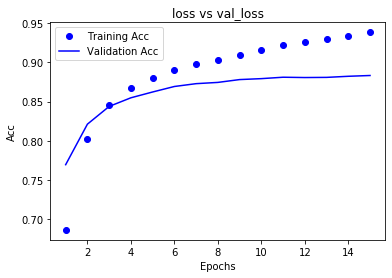

In [63]:
# Plot acc vs val acc 
plt.plot(epochs, acc, 'bo', label ='Training Acc')
plt.plot(epochs, val_acc, 'b', label ='Validation Acc')
plt.title('loss vs val_loss')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Export the model

In [64]:
# Create a new model using the weights you just trained. Include the TextVectorization
# layer inside your model so model is capable of processing raw strings


export_model = tf.keras.Sequential([
    vectorize_layer,model,layers.Activation('sigmoid')
])

export_model.compile(\
                    loss = losses.BinaryCrossentropy(from_logits=False),
                    optimizer='adam', metrics=['accuracy'])

# Testing with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3178 - accuracy: 0.8679
0.8714799880981445


# Inference on new data

In [65]:
example_reviews =[
    'This movie sucks so bad its the worst',
    'This movie is great I really enjoyed it',
    'I like the actors but the story is really bad'
]

export_model.predict(example_reviews)

array([[0.06495965],
       [0.6943211 ],
       [0.2578559 ]], dtype=float32)